# Predictive Process Monitoring - Data Loading \& Exploration

This notebook is part of the [starter package](https://github.com/fmannhardt/starter-predictive-process-monitoring) for predictive process monitoring. It contains examples for data loading from event logs for the purpose of developing and applying predictive process monitoring techniques.

## Setup
The following Python libraries are used, please refer to the installation instructions to prepare your environment:

* [PM4Py](https://pm4py.fit.fraunhofer.de/)
* [Pandas](https://pandas.pydata.org/)

In [6]:
import pandas as pd
import pm4py

'2.7.9.2'

## Event Log 

We are using a publicly available event log called Sepsis Cases as an example.

### CSV File
Event logs can be loaded with Pandas from CSV files and are then converted to an event log by PM4Py by specifying columns for the three main requirements of an event log: case identifier, activity identifier, and timestamps. 

In [91]:
# sepsis = pd.read_csv("../data/sepsis.csv", sep=';')
# # sepsis.dropna(subset=["case_id","activity","timestamp"], inplace=True)
# sepsis["timestamp"]=pd.to_datetime(sepsis["timestamp"],format='%Y-%m-%dT%H:%M:%SZ')
# sepsis_log = pm4py.utils.format_dataframe(sepsis, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

# # sepsis_log
# sepsis_log = pm4py.convert.convert_to_event_log(sepsis_log,case_id_key="case_id")

import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/kang/gcp/precise-valor-402512-936910207d8a.json'


from google.cloud import bigquery
bigquery_client=bigquery.Client()

query = """
SELECT * FROM `precise-valor-402512.netsuite_suiteanalytics.transactionhistory`
"""

query_result = bigquery_client.query(query)
# query_result.result()
result = query_result.to_dataframe()
result
# destination=query_result.destination


# destination=bigquery_client.get_table(destination)


# rows = bigquery_client.list_rows(destination,max_results=20)

# for row in rows:
#     print(row)



# df=  query_result.to_dataframe()
# df.head()

SyntaxError: invalid syntax (135827440.py, line 16)

Ignore the Pandas warning which is due to some internal issue in PM4Py and let us check if the import succeeded:

In [90]:
len(sepsis_log)


1049

### XES File

Alternatively, PM4PY can also load the event log directly from a file in the standardized XES file format for event log.

In [ ]:
from urllib.request import urlretrieve
import os

# download from 4tu.nl
urlretrieve('https://data.4tu.nl/ndownloader/files/24061976', 'sepsis0.xes.gz')
sepsis_log = pm4py.read_xes('sepsis0.xes.gz')
os.unlink('sepsis0.xes.gz') # clean up

In [10]:
len(sepsis_log)

15190

## Data Exploration

It is a good idea to perform some data exploration to investigate the properties of the event log. Please note that there are much more capabilities in ProM. So, do not limit yourself to using PM4Py.

In [56]:
# number of distinct trace variants
len(pm4py.get_variants_as_tuples(sepsis_log))

845

In [57]:
# how does the process start
pm4py.get_start_activities(sepsis_log)

{'ER Registration': 994,
 'ER Sepsis Triage': 7,
 'CRP': 10,
 'Leucocytes': 18,
 'IV Liquid': 14,
 'ER Triage': 6}

In [58]:
# how does the process end
pm4py.get_end_activities(sepsis_log)

{'Release A': 393,
 'IV Antibiotics': 87,
 'Return ER': 291,
 'LacticAcid': 24,
 'Admission NC': 14,
 'CRP': 41,
 'ER Sepsis Triage': 49,
 'Leucocytes': 44,
 'IV Liquid': 12,
 'Release B': 55,
 'Release E': 5,
 'Release C': 18,
 'Release D': 14,
 'ER Triage': 2}

In [59]:
from pm4py.objects.log.util.log import project_traces
def print_nth(log, index):
    print(str(project_traces(sepsis_log)[index]))

In [60]:
print_nth(sepsis_log, 0)

['ER Registration', 'Leucocytes', 'CRP', 'LacticAcid', 'ER Triage', 'ER Sepsis Triage', 'IV Liquid', 'IV Antibiotics', 'Admission NC', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Leucocytes', 'CRP', 'CRP', 'Leucocytes', 'Release A']


In [61]:
print_nth(sepsis_log, 1)

['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'Leucocytes', 'LacticAcid', 'CRP', 'IV Liquid', 'IV Antibiotics']


Let us look at the directly-follows graph of the whole event log:

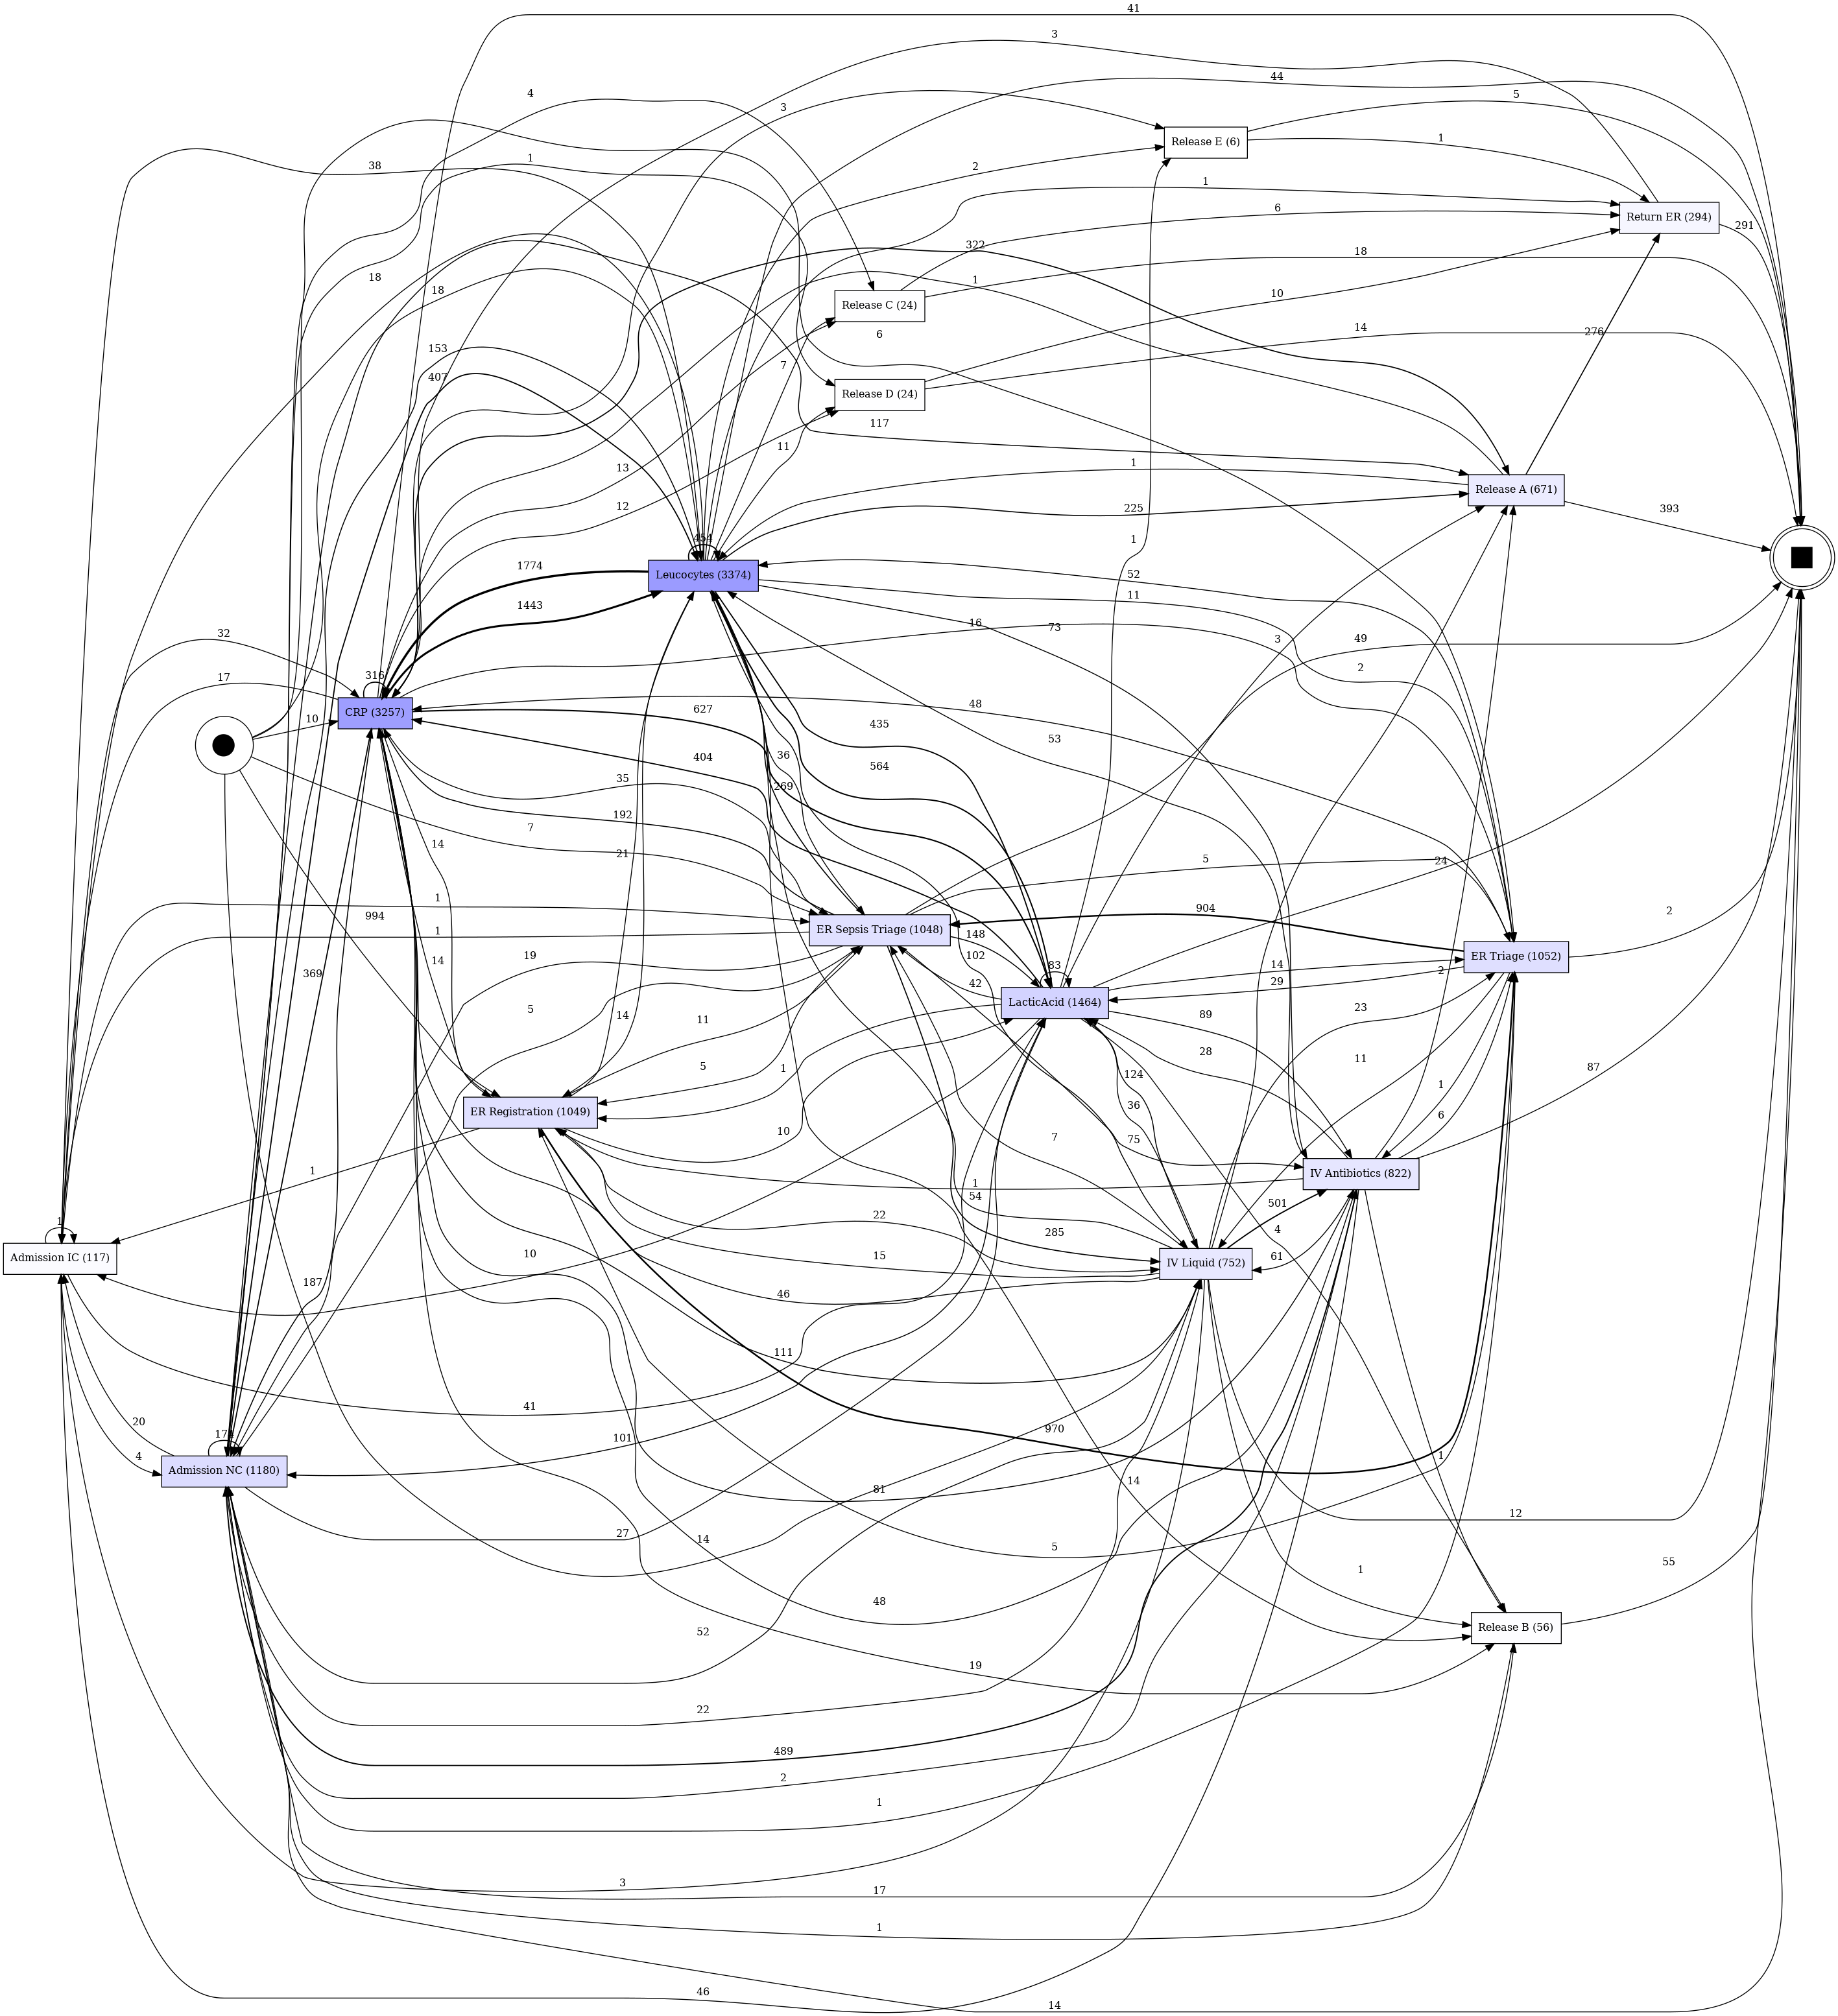

In [63]:
dfg, start_activities, end_activities = pm4py.discover_dfg(sepsis_log)
pm4py.view_dfg(dfg, start_activities, end_activities)

A quite messy process. There are countless filtering options in PM4Py that allow you to focus on a subset of the data. For example, what happens if we remove the very frequently repeating activities: Leucocytes, CRP, LacticAcid.

In [64]:
sepsis_log_filtered = pm4py.filter_event_attribute_values(sepsis_log, 
                                    attribute_key = 'concept:name', # special column for the activity name always added by PM4Py
                                    values = ['LacticAcid', 'CRP', 'Leucocytes'], 
                                    level = 'event',    # we want to keep all traces and modify events
                                    retain = False)     # remove matching events

/home/kang/.local/lib/python3.10/site-packages/pm4py/utils.py:536: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


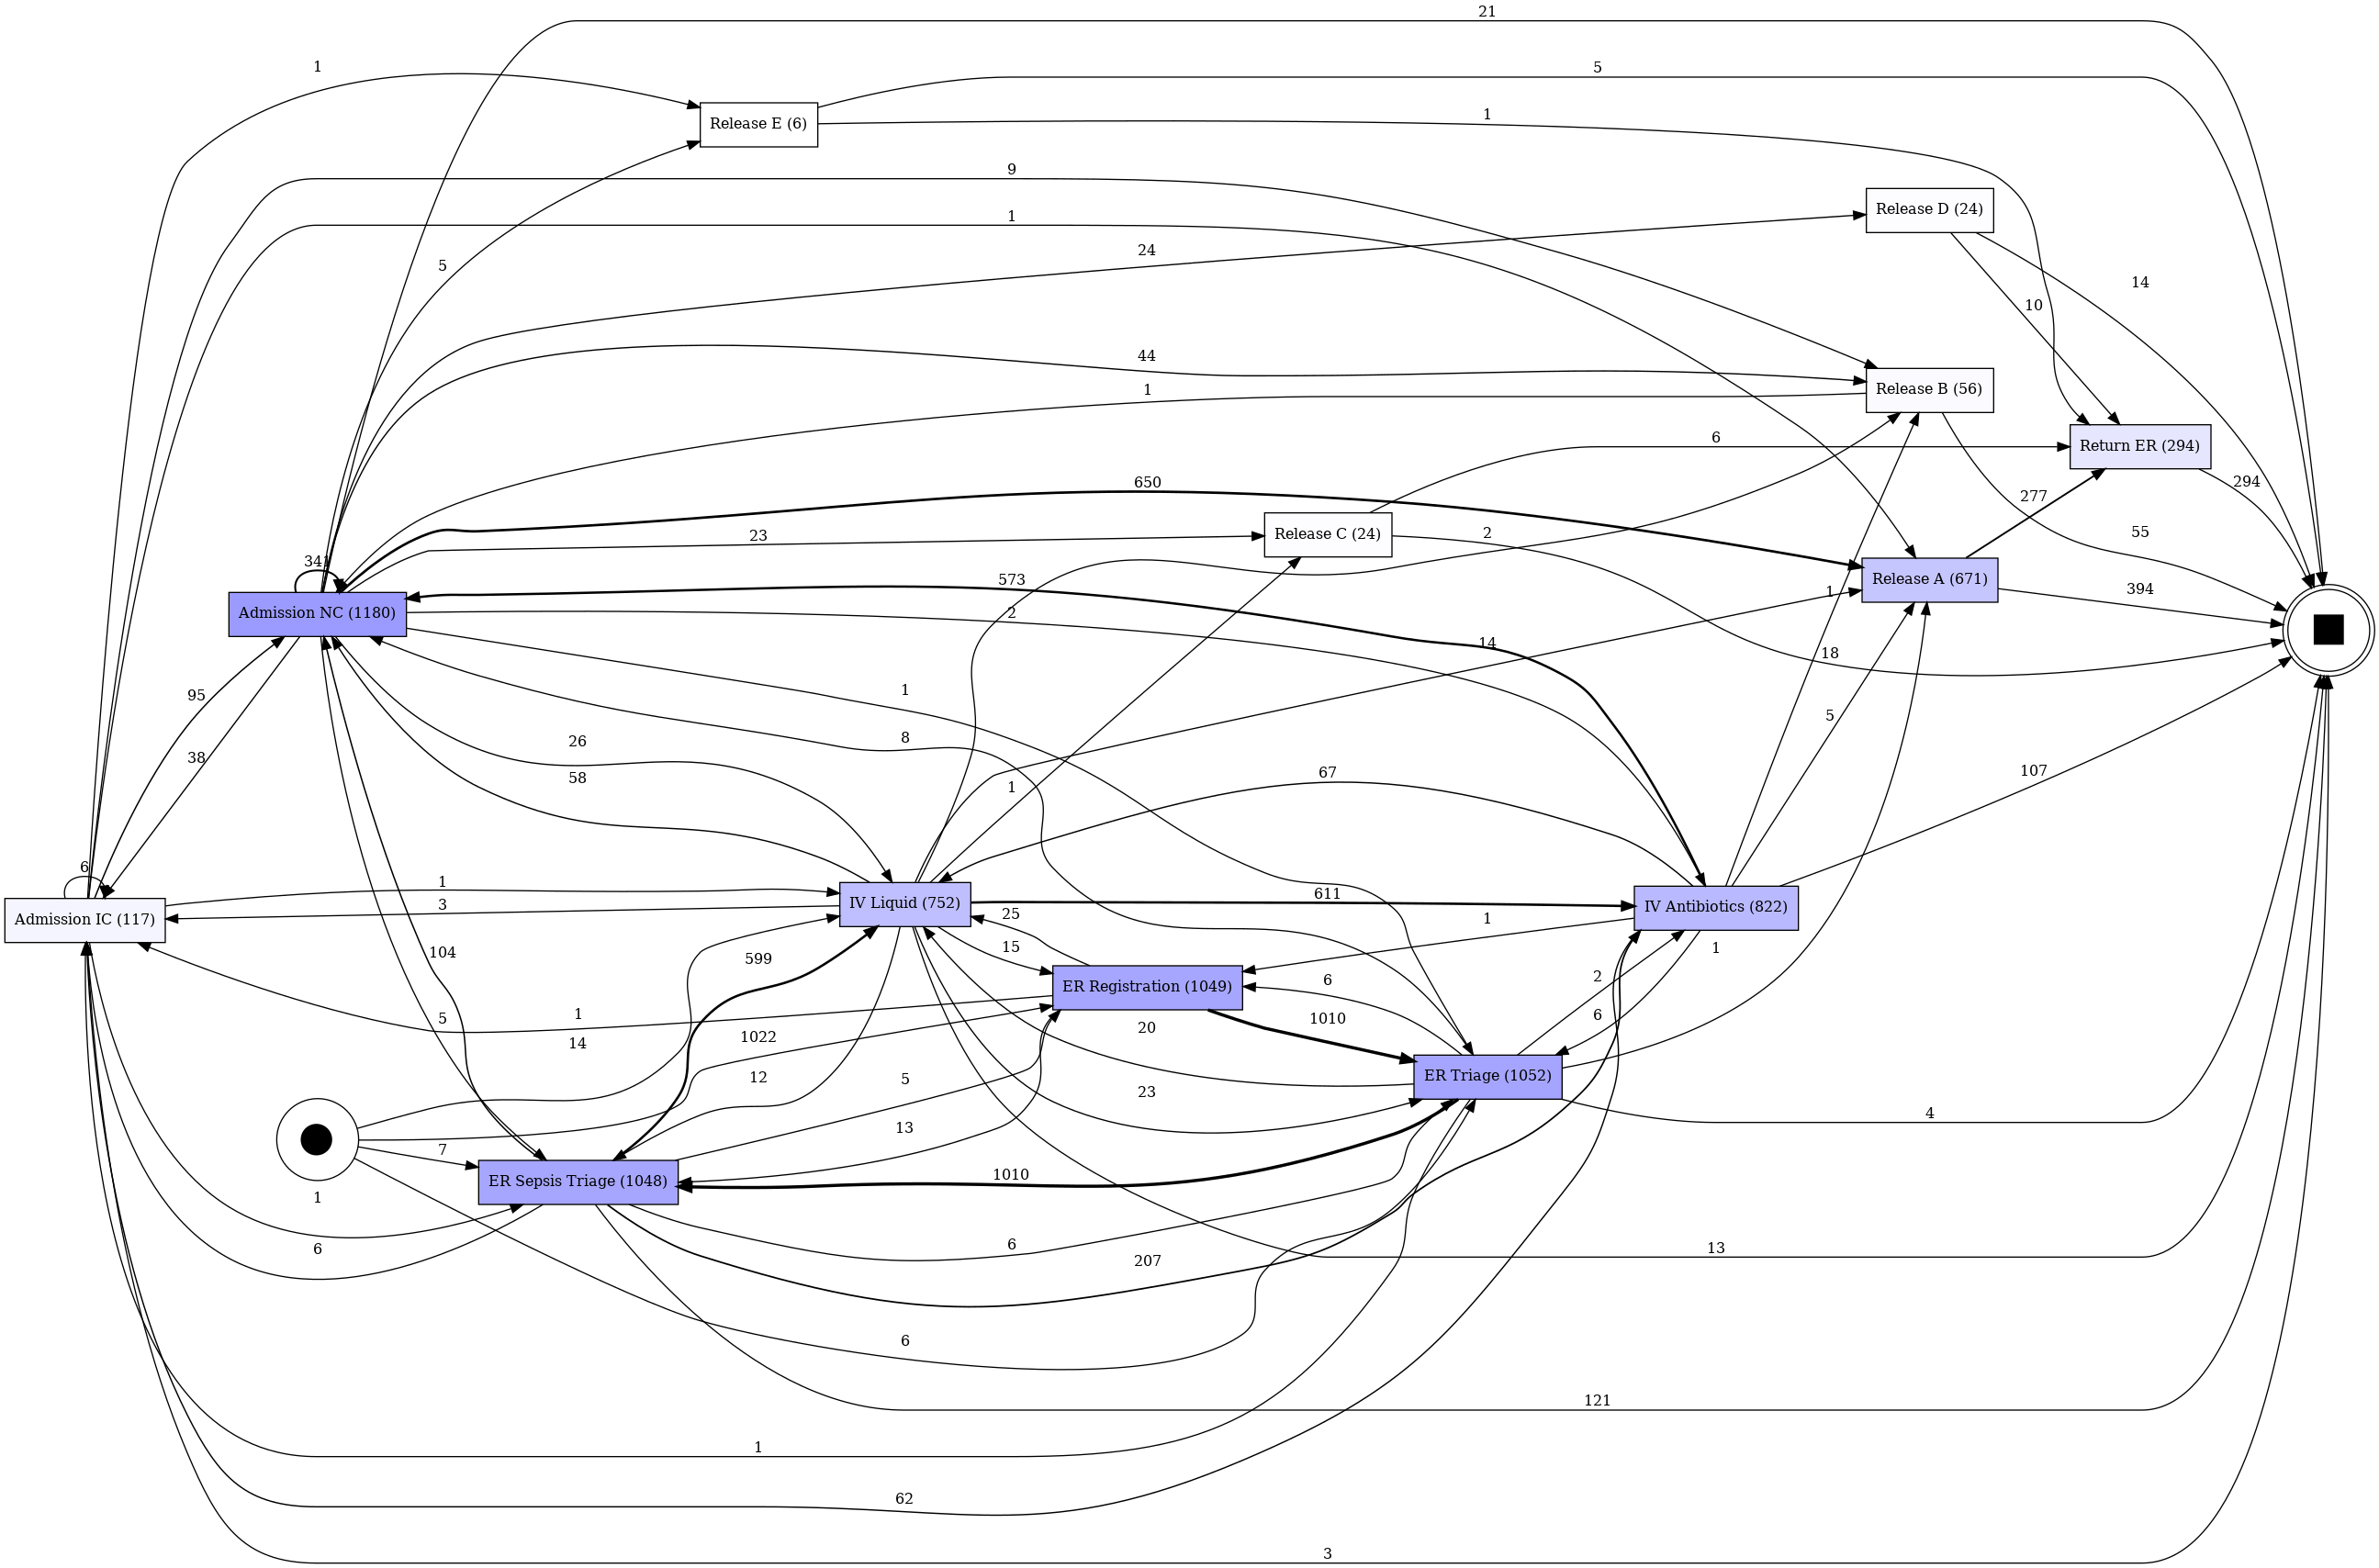

In [65]:
dfg, start_activities, end_activities = pm4py.discover_dfg(sepsis_log_filtered)
pm4py.view_dfg(dfg, start_activities, end_activities)

A bit more comprehensible but more filtering or pre-processing could be performed, explore the PM4Py documentation on what is possible:

https://pm4py.fit.fraunhofer.de/documentation#filtering

You can also look at the trace or event attributes in an event log to generate suitable subsets.

In [66]:
pm4py.get_event_attributes(sepsis_log)

['age',
 'infectionsuspected',
 'case_id',
 'infusion',
 'sirscritleucos',
 '@@case_index',
 'diagnosticxthorax',
 'diagnose',
 'sirscrittemperature',
 'diagnosticecg',
 '@@index',
 'sirscritheartrate',
 'timestamp',
 '.order',
 'leucocytes',
 'activity',
 'diagnosticblood',
 'diagnosticliquor',
 'oligurie',
 'concept:name',
 'case:concept:name',
 'resource',
 'sirscriteria2ormore',
 'disfuncorg',
 'diagnosticartastrup',
 'time:timestamp',
 'crp',
 'diagnosticurinaryculture',
 'lacticacid',
 'diagnosticlacticacid',
 'activity_instance_id',
 'hypoxie',
 'diagnosticother',
 'diagnosticic',
 'hypotensie',
 'diagnosticsputum',
 'diagnosticurinarysediment',
 'sirscrittachypnea',
 'lifecycle']

The set of values of a specific event attribute can be extracted. A 'nan' indicates that there are many events without such attribute:

In [67]:
pm4py.get_event_attribute_values(sepsis_log, 'Diagnose')

{}